<a href="https://colab.research.google.com/github/sunnyanthony/diffusion_playground/blob/experiment/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Process and Reverse Process

## Specific Prerequisites
* Markov Chain in Probability Graph Module
* Variational Autoencoder
* U-Net

## Noise Process

$q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)$

$q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})$
### Reparametriation
$$
    \alpha_t = 1 - \beta_t \\
    \bar \alpha_t = \prod_{i=1}^t \alpha_i \\
    \epsilon \sim N(0, I)\\
    x_t = \sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\epsilon\\
    = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon\\
    = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\epsilon\\
    = ... \\
    =\sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon \\
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I) \\
$$

## Autoencoder
Autoencoder is a neural network to learn the characteristic of the data. It has some features as follows:
1. input and target are the same via downsampling and upsampling
  * kind of unsupervised-learning
2. has power to reduce the dimension in the encoder part    
    
We use it to predict noise in U-Net. Even if the U-Net could use to predict $x_0$ from $x_t$, the preformace is pretty bad.


## Denoising Process
$p_\theta(x_{t-1}|x_t)$ is reverse process of the noise process. In here, the model does not know $q(x_{t-1}|x_t)$ (not $q(x_t|x_{t-1})$). It's hard to calculate $q(x_{t-1}|x_t)$.
Hence, we guess the reverse distribution is almost like Gaussion distribution.
$$
  p_\theta(x_{t-1}|x_t) = N(x_{t-1};\mu_\theta(x_t,t), {\sum}_\theta(x_t,t))\\
  s.t.\ p_\theta(x_{0:T}) = p(x_T)\prod^T_t p_\theta(x_{t-1}|x_t)
$$
Therefore, we use deep learning to lean the $\mu$ and $\sum$ for the reverse distribution. The loss function is from cross-entropy of Markov chain of condition probability and it's similar to $L_{VAE}$.
$$
  L = \sum_t^T L_{t}\\
  L_t =  D_{KL}(q(x_t|x_{t+1}, x_0) \| p_\theta(x_{t}|x_{t+1}))\\
  L_0 = -ln\ p_\theta(x_0|x_1)\\
  L_T = D_{KL}(q(x_T, x_0) \| p_\theta(x_{T}))
$$
    
The mean and variance are $\tilde \mu(x_t, x_0) = \frac{\sqrt{1-\beta_{t-1}}x_{t}}{1-\bar \alpha_t}x_0+ \frac{\sqrt{\alpha_t}(1-\bar \alpha_{t-1})}{1-\bar \alpha_t}x_t$ and Var is $\tilde\beta_t I = \frac{(1-\bar \alpha_{t-1})}{1-\bar \alpha_t}\beta_t I$. And the $L_{t-1}$ approximates to $E_{x,\epsilon}[\frac{1}{2\|{\sum}_\theta\|_2^2}\|\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]$.
However, it's still complicated. What's if we predict $\epsilon$ ?
$$
\mu(x_t, t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) = x_{t-1}\\
  L_{t-1} = E_{x_t, \epsilon}[\frac{\beta_t^2}{2\alpha_t(1-\bar \alpha_t)\|{\sum}_\theta\|_2^2}\|\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t}x_0 + \sqrt{1 - \bar \alpha_t}\epsilon, t)\|_2^2]
$$

### Algorithms
* Training
  0. loop
  1. $x_0 \sim q(x_0)$
  2. $t \sim U(0,T)$
  3. $\epsilon \sim N(0,I)$
  4. $\theta = \theta + \nabla_\theta MSE(\epsilon, \epsilon_\theta(\sqrt{\bar \alpha_t}x_0 + \sqrt{1 - \bar \alpha_t}\epsilon, t))$
* Sampling
  1. $x_T \sim N(0, I)$
  2. for loop in steps $t\ in\ [T:0]$
  3. $\ \ x_{t-1}=\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) + \sigma_t Z$
  4. return $x_0$    

**$\epsilon_\theta$ is `U-Net` neual network model.**

### Embedding
1. Use `sinusoidal positione mbedding` to define the postion of the noise in the sequence.
2. Use `cosin similarity` to train image-text pair to get the texts encoder to embed text with position into image.

In [1]:
from enum import Enum, auto
class Beta():
  class schedule(Enum):
    linear = auto()
    cosin = auto()

  def __init__(self, start, end, times):
    """
    diffusion rate scheduler
    """
    self.start = start
    self.end = end
    self.times = times
    if not all([0.0 <= self.start < 1.0, 0.0 <= self.end < 1.0, self.start < self.end]):
      raise ValueError("Beta should between 0.0 and 1.0")

  def get_schedule(self, typeof: schedule):
    if typeof == Beta.schedule.linear:
      return np.linspace(self.start, self.end, self.times)
    elif typeof == Beta.schedule.cosin:
      """
      Alex Nichol, Prafulla Dhariwal (2021), Improved Denoising Diffusion Probabilistic Models
      \beta = 1 - \frac{\bar \alpha_t}{\bar \alpha_{t-1}}
      """
      import math
      def bar_alpha(t, s = 0.008):
        """
        f = cos(\frac{t/T+s}{1+s} \frac{\pi}{2})^2,\ where\ s=0.008
        """
        return (math.cos((t + s) / (1+s) * math.pi / 2) ** 2)
      clip_beta = 0.999
      return np.array([min(1 - bar_alpha((i) / self.times) / bar_alpha( (i-1) / self.times), clip_beta) for i in range(1, self.times+1)])
    return None

In [2]:
from IPython.utils.frame import extract_vars_above
import numpy as np
import torch


class GaussianDiffusion():
  """
  q is forward process
  p is backward process
  """

  def __init__(self,
               beta: Beta,
               times = None,
               schedulerType = Beta.schedule.linear):
    """
    q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)
    q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})

    Reparametriation: for the close-form representation
    \alpha_t = 1 - \beta_t
    \bar \alpha_t = \prod_{i=1}^t \alpha_i
    q(x_t|x_{t-1}) = \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    """
    self.B = beta
    self.betas = self.B.get_schedule(schedulerType)
    if self.betas is None:
      raise Exception("please check the schedule type")
    self.times = times
    self.alphas = 1 - self.betas
    self.alphas_hat = np.cumprod(self.alphas, axis=0)

    self.alphas_prodprev = np.append(1.0, self.alphas_hat[:-1])

    # For \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    # and N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    # that shared the \sqrt{\bar \alpha_t} and \sqrt{1-\bar \alpha_t}
    self.firstpart_q_alphas_hat = np.sqrt(self.alphas_hat)
    self.secondpart_q_alphas_hat = np.sqrt(1.0 - self.alphas_hat)

  def noise(self, x_0):
    """
    standard distribution sampling
    """

    if torch. is_tensor(x_0):
      return torch.randn_like(x_0)
    else:
      return np.random.randn(*x_0.shape)

  def q_sample(self, x_0, t, noise=None):
      """
      Forward: noising
      return x_t
      """
      if noise is None:
          noise = self.noise(x_0) # epsilon
      return self.firstpart_q_alphas_hat[t] * x_0 \
          + self.secondpart_q_alphas_hat[t] \
          * noise

  def p_sample(self, predictor: torch.nn.Module, x_t, t, texts=None, printing=False):
    """
    TODO: change to torch.tensor
    """
    """
    x_{t-1}=\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) + \sigma_t Z
    """
    if self.betas is None:
      raise Exception("please create instance with bets")
    betas_t = torch.Tensor([self.betas[t]]).to(x_t.device)

    noise = predictor(x_t, t, texts) if texts is not None else predictor(x_t, t)

    # \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t))
    x_t_1 = torch.sqrt(1.0 / torch.Tensor([self.alphas[t]]).to(x_t.device)) * \
          ( torch.Tensor(x_t).to(x_t.device) - \
          ( betas_t / torch.Tensor([self.secondpart_q_alphas_hat[t]]).to(x_t.device)) * noise)
    if printing:
      print(f"{noise=}")
      print(f"{betas_t / torch.Tensor([self.secondpart_q_alphas_hat[t]]).to(x_t.device) * noise}")

    # \sigma_t Z
    alphas_hat_1 = nn.functional.pad(torch.Tensor([self.alphas_hat[:-1]]).to(x_t.device), (1, 0), value=1.0)
    temp = torch.Tensor([self.betas]).to(x_t.device) * (1.0 - alphas_hat_1) / (1.0 - torch.Tensor([self.alphas_hat]).to(x_t.device))
    temp = temp[0][t]
    temp = torch.sqrt(temp)
    extra = temp * torch.randn_like(x_t) if t > 0 else 0
    if printing:
      print(extra)
      print(x_t_1 + extra)

    return x_t_1 + extra


  def loss_function(self, x_0, epsilon_theta_module: torch.nn.Module, steps=100, t=None, epsilon=None, texts=None):
    """
    E_{x,\epsilon}[const*\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]
    const = \frac{1}{2\|{\sum}_\theta\|_2^2}\|
    => \hat E_{x,\epsilon}[\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]
    """
    t = torch.randint(0, steps, (x_0.shape[0],), dtype=torch.long) if t is None else t
    epsilon = torch.randn_like(x_0, device=x_0.device) if epsilon is None else epsilon
    xt = self.q_sample(x_0, t, noise=epsilon)
    xt.to(next(epsilon_theta_module.parameters()).device)

    eps_theta = epsilon_theta_module(xt, t, texts) if texts is not None else epsilon_theta_module(xt, t)
    loss = torch.nn.MSELoss()
    ret = loss(eps_theta, epsilon) # it would gradient MSE for SGD
    return ret

In [17]:
from torch import nn
import math
class UNet(nn.Module):
  """
  please please please read Olaf Ronneberger, Philipp Fischer, Thomas Brox (2015),
  U-Net: Convolutional Networks for Biomedical Image Segmentation
  The structure is downsampling and upsampling, and connecting to each blocks.
  """

  class TimeEmbedded(nn.Module):
    def __init__(self, dim):
      super().__init__()
      self.dim = dim
  
    def forward(self, x):
      """
      Vaswani et al. (2017)
      PE_(pos,2i) = sin(pos/10000^(2i/d_model))
      PE_(pos,2i+1) = cos(pos/10000^(2i/d_model))

      According to https://huggingface.co/blog/annotated-diffusion, 
      https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL#scrollTo=buW6BaNga-XH,
      and https://pytorch.org/tutorials/beginner/transformer_tutorial.html
      I don't know why we need to logarithmize the number. 
      """
      temp_term = -math.log(10000) / (self.dim//2 - 1) # log (10000^(2 / dim)) = (log(10000)*2) / dim
      div_term = torch.exp(torch.arange(start=0, end = self.dim, step=2, device=x.device) * temp_term)
      embedded = x[:, None] * div_term[None,:]
      return torch.cat((embedded.sin(), embedded.cos()), dim = -1)

  class Conv3x3ReLU(nn.Module):
    def __init__(self, insize, out, time_dim, padding = 1, dim = 2, stride=1, bias = True):
      super().__init__()

      class_nd = getattr(nn, f"Conv{dim}d") # exception if not found
      self.conv0 = class_nd( in_channels = insize, out_channels = out,
                            kernel_size = 3, padding = padding, bias = bias,
                            stride = stride)
      self.relu0 = nn.ReLU(inplace=True)
      self.conv1 = class_nd( in_channels = out, out_channels = out,
                            kernel_size = 3, padding = padding, bias = bias,
                            stride = stride)
      self.relu1 = nn.ReLU(inplace=True)

      # avoid the output exp...
      self.bnorm0 = nn.BatchNorm2d(out)
      self.bnorm1 = nn.BatchNorm2d(out)

      # refer to openai/guided-diffusion
      self.emb_layers = nn.Sequential(
            nn.Linear(time_dim,out),
            nn.SiLU(),
            nn.Linear(out,out),
            )

    def forward(self, x, time_embedded = None):
      for i in range(2):
        if i == 1 and time_embedded is not None:
          e = self.emb_layers(time_embedded)
          while len(e.shape) < len(x.shape):
            e = e[..., None]
          x = x + e
        x = getattr(self, f"relu{i}")(getattr(self, f"conv{i}")(x))
        x = getattr(self, f"bnorm{i}")(x)
      return x

  class Conv3x3GeLU(Conv3x3ReLU):
    def __init__(self, insize, out, time_dim, padding = 1, dim = 2, stride=1, bias = True):
      super().__init__(insize, out, time_dim, padding, dim, stride, bias)
      self.relu0 = torch.nn.GELU()
      self.relu1 = torch.nn.GELU()

  class MaxPooling2x2(nn.Module):
    def __init__(self, dim = 2):
      super().__init__()
      maxpool_nd = getattr(nn, f"MaxPool{dim}d")
      self.pooling = maxpool_nd(kernel_size = 2, stride=2) # stride would as same as kernel which would sample to half of the data

    def forward(self, x):
      return self.pooling(x)

  class UpPooling(nn.Module):
    def __init__(self, insize, out, time_dim,
                 dim = 2,
                 mode = None,
                 kernelsize=3,
                 kernelsize_up = 2,
                 stride = 2,
                 padding = 0,
                 bias=False):
      super().__init__()
      class_nd = getattr(nn, f"Conv{dim}d")
      mid = int(2**((np.log2(insize)  + np.log2(out)) // 2))
      if mode:
        self.sample = nn.Sequential(
            nn.Upsample(mode=mode, scale_factor=2),
            class_nd( mid, out, kernel_size=1, groups=1, stride=stride)
            )
      else:
        uplearnableclass = getattr(nn, f"ConvTranspose{dim}d")
        self.sample = uplearnableclass(in_channels=mid, out_channels=out, kernel_size=kernelsize_up,
                                       stride=stride+1, padding=padding-1)
      self.conv = class_nd( in_channels=insize, out_channels=mid,
                            kernel_size=kernelsize, bias=bias, stride=stride, padding=padding)
      
      # refer to openai/guided-diffusion
      self.emb_layers = nn.Sequential(
            nn.Linear(time_dim, out),
            nn.SiLU(),
            nn.Linear(out, out*4),
            )

    def forward(self, x, time_embedded = None):
      if time_embedded is not None:
        e = self.emb_layers(time_embedded)
        while len(e.shape) < len(x.shape):
            e = e[..., None]
        x = x + e
      y = self.conv(x)
      return self.sample(y)

  def __init__(self, input_size, out_size, features, time_dim=None, bias = True):
    super().__init__()

    self.time_embedding = nn.Sequential(
        self.TimeEmbedded(time_dim),
        nn.Linear(time_dim, time_dim),
        nn.SiLU(),
    ) if time_dim else None

    exp = 0
    self.inlayer1 = self.Conv3x3GeLU(input_size, features*(2**exp), time_dim); exp += 1
    self.expend1 = nn.Conv2d( in_channels = features*(2**(exp-1)), out_channels = features*(2**(exp)),
                            kernel_size = 3, bias = bias, stride = 1, padding=1)
    self.inlayer2 = self.Conv3x3GeLU(features*(2**(exp-1)), features*(2**exp), time_dim); exp += 1
    self.expend2 = nn.Conv2d( in_channels = features*(2**(exp-1)), out_channels = features*(2**(exp)),
                            kernel_size = 3, bias = bias, stride = 1, padding=1)
    self.inlayer3 = self.Conv3x3GeLU(features*(2**(exp-1)), features*(2**exp), time_dim); exp += 1
    self.expend3 = nn.Conv2d( in_channels = features*(2**(exp-1)), out_channels = features*(2**(exp)),
                            kernel_size = 3, bias = bias, stride = 1, padding=1)
    self.inlayer4 = self.Conv3x3GeLU(features*(2**(exp-1)), features*(2**exp), time_dim); exp += 1
    self.expend4 = nn.Conv2d( in_channels = features*(2**(exp-1)), out_channels = features*(2**(exp)),
                            kernel_size = 3, bias = bias, stride = 1, padding=1)

    self.maxpool1 = self.MaxPooling2x2()
    self.maxpool2 = self.MaxPooling2x2()
    self.maxpool3 = self.MaxPooling2x2()
    self.maxpool4 = self.MaxPooling2x2()

    self.bottom = self.Conv3x3ReLU(features*(2**(exp-1)), features*(2**exp), time_dim)
    self.up = nn.Upsample(mode="bilinear", scale_factor=2)


    self.outlayer = nn.ModuleList([self.UpPooling(features*(2**i)*2, features*(2**(i-1)), \
                                                  time_dim, kernelsize = 3, bias = bias, \
                                                  stride = 1, padding=1) \
                                  for i in range(exp, 0, -1)]); exp = 0

    self.conv1x1 = nn.Conv2d( in_channels = features*(2**exp), out_channels = out_size,
                            kernel_size = 2, bias = bias, stride = 2, padding=0)
    
  def forward(self, x, timestamp):

    time_position_embedded = self.time_embedding(timestamp) if self.time_embedding else None

    in1 = self.inlayer1(x, time_position_embedded)
    in2 = self.inlayer2(self.maxpool1(in1), time_position_embedded)
    in3 = self.inlayer3(self.maxpool2(in2), time_position_embedded)
    in4 = self.inlayer4(self.maxpool3(in3), time_position_embedded)

    out = self.up(self.bottom(self.maxpool4(in4)))

    inlist = [self.expend4(in4), self.expend3(in3), self.expend2(in2), self.expend1(in1)]
    for i, ol in enumerate(self.outlayer):
      merge = torch.cat((out, inlist[i]), dim=1)
      out = ol(merge, time_position_embedded)
    out = self.conv1x1(out)
    return out


## Train signal image

In [ ]:
from pathlib import Path
from tqdm import tqdm
from torchvision import transforms
from pathlib import Path
from google.colab import drive
import sys

drive.mount('/content/gdrive/')

device = torch.device('cuda:0' if torch.cuda.is_available() else "mps" \
                    if torch.backends.mps.is_available() else 'cpu')
steps = 300 #steps

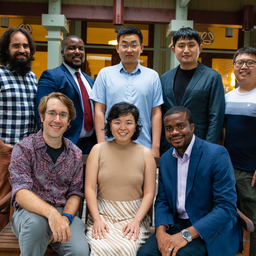

In [23]:
from PIL import Image, ImageOps
import requests
from io import BytesIO

size = (256, 256)
url = "https://cs.vt.edu/content/website_cs_vt_edu/en/faculty-search/jcr:content/article-image.transform/xl-medium/image.jpg"
response = requests.get(url)
content = BytesIO(response.content)
img = Image.open(content)
img = ImageOps.fit(img, size, Image.ANTIALIAS)
#img.thumbnail(size, Image.ANTIALIAS)
img.show()

In [ ]:
"""
Jonathan Ho, Ajay Jain, Pieter Abbeel (2020), Denoising Diffusion Probabilistic Models
recommends the beta should from 0.0001 to 0.02
"""
scheduler_end = 0.02
scheduler = "cosin"
learning_rate = 1e-6

PATH_PT = '/content/gdrive/MyDrive/testdata/{}_deffusion_model_fixed.pt'

model = UNet(3, 3, 32, steps)
if Path(PATH_PT.format(scheduler)).is_file():
  model.load_state_dict(torch.load(PATH_PT.format(scheduler), map_location=torch.device(device)))
  print("loading")
  model.train()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
diffusion_model = GaussianDiffusion(Beta(0.0001, scheduler_end, steps+1), schedulerType=Beta.schedule.cosin if scheduler == "cosin" else Beta.schedule.linear )
transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

img_test = np.array(img.convert('RGB'))
img_test = transform_ops(img_test)
img_test = img_test[None,::]
# data to device in not in-place
img_test = img_test.to(device)

for epoch in (pbar:= tqdm(range(50))):
  #torch.cuda.synchronize()
  loss_total = 0.0
  for t in range(0, steps+1)[::-1]:
    epsilon = torch.randn_like(img_test, device=img_test.device)
    T = torch.Tensor([t]).type(torch.int64).to(device)
    optimizer.zero_grad()
    loss = diffusion_model.loss_function(img_test, model, t=T, epsilon=epsilon) #steps, epsilon_theta: nn.Module, epsilon = None
    loss_total += loss.item()
    loss.backward()
    optimizer.step()
  pbar.set_description(f"loss {loss_total/steps}")
  torch.save(model.state_dict(), PATH_PT.format(scheduler))
torch.save(model.state_dict(), PATH_PT.format(scheduler))
print("\nsaved")

loading


loss 0.04684983185802897:  68%|██████▊   | 34/50 [08:30<04:00, 15.02s/it]

In [ ]:
from torchvision import transforms 
import matplotlib.pyplot as plt
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

# generate a random image
rand_img = torch.randn_like(img_test)
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = 30
model.eval()
for i in range(0,300)[::-1]:
    with torch.no_grad():
      t = torch.tensor([i]).to(next(model.parameters()).device)
      rand_img.to(next(model.parameters()).device)
      _rand_img = diffusion_model.p_sample(model, rand_img, t)
      rand_img = _rand_img
      if i % stepsize == 0:
          plt.subplot(1, num_images, int(i/stepsize+1))
          show_tensor_image(rand_img.detach().cpu())

plt.show()

<ipython-input-7-fc92ac7d481b>:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize+1))


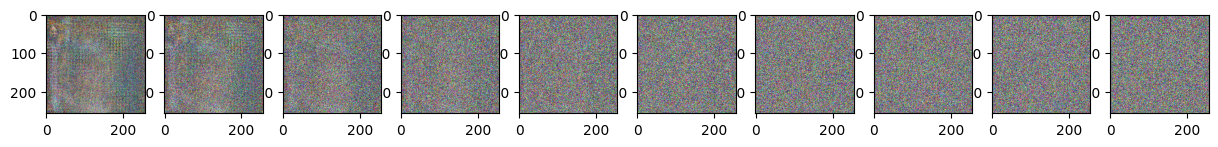

In [ ]:
from torchvision import transforms 
import matplotlib.pyplot as plt
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

# generate a random image
rand_img = torch.randn_like(img_test)
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = 30
model.eval()
for i in range(0,300)[::-1]:
    with torch.no_grad():
      t = torch.tensor([i]).to(next(model.parameters()).device)
      rand_img.to(next(model.parameters()).device)
      _rand_img = diffusion_model.p_sample(model, rand_img, t)
      rand_img = _rand_img
      if i % stepsize == 0:
          plt.subplot(1, num_images, int(i/stepsize+1))
          show_tensor_image(rand_img.detach().cpu())

plt.show()

# Ordinary Training
1. image-text pairs training for text embedded
2. use text embedded to merge position and text into image
3. diffusion training

TODO:
use nn.LayerNorm

In [4]:
from google.colab import drive
import sys
import torch

drive.mount('/content/gdrive/')
data_dir = '/content/gdrive/MyDrive/testdata/cityscapes_data'
ordinary_dir = '/content/gdrive/MyDrive/testdata/dataset/RoboCup2018/train'
steps = 300 # for timestamp and textembedding
device = torch.device('cuda:0' if torch.cuda.is_available() else "mps" \
                    if torch.backends.mps.is_available() else 'cpu')
batch_size = 10

Mounted at /content/gdrive/


In [5]:
import shutil
from pathlib import Path

shutil.copytree(ordinary_dir, Path("/content/RoboCup2018/train"))
ordinary_dir = "/content/RoboCup2018/train"

In [6]:
from torch import nn
import torchvision
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


def loadclass(classes_file, classes: dict, postfix='.jpg'):
  import os
  import regex as re

  vocabulary = set()
  with open(classes_file) as fd:
    for i in fd.readlines():
      m1 = re.search('\d+(?=.xml:)',i)
      m2 = re.search('(?<=<name>).*(?=</name>)', i)
      classes[m1.group(0)+postfix] = m2.group(0)
      vocabulary.add(m2.group(0))
  return vocabulary


class OrdinaryDataset(Dataset):
    
    def __init__(self, image_dir, classes_file, num_items = 1000, image_x = 256,
                 image_y = 256, original_image_width = 256):
        self.image_dir = image_dir
        self.image_x = image_x
        self.image_y =image_y
        self.image_fns = os.listdir(image_dir)
        self.classes = dict()
        vocabulary = loadclass(classes_file, self.classes)
        self.classes2index = {x: i for (i, x) in enumerate(vocabulary)}
        self.index2classes = {i: x for (i, x) in enumerate(vocabulary)}
        for k in self.classes.keys():
          self.classes[k] = self.classes2index[self.classes[k]]
        self.num_classes = len(vocabulary)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = ImageOps.fit(image, (self.image_x, self.image_y), Image.ANTIALIAS)
        image = np.array(image)
        image = self.transform(image)
        label_class = self.classes[image_fn]
        return image, label_class
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

dataset = OrdinaryDataset(os.path.join(ordinary_dir, "images256"), classes_file=os.path.join(ordinary_dir, "classes.txt"))
data_loader = DataLoader(dataset, batch_size=batch_size)

## text-image pair similarity training

In [7]:
from torch.nn import CosineSimilarity
import torch.nn.functional as F
import torch
from tqdm import tqdm

class TextEncoder(torch.nn.Module):
  def __init__(self, text_class, output):
    """
    texts transformer encoder need position embedded to do attention
    however, we only embed "a word" instead of sentence.
    It should be keeping as simple as possible.
    """
    super().__init__()

    text_list = [
        torch.nn.Linear(text_class, text_class*100),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(text_class*100, output),
    ]
    self.encoder = torch.nn.Sequential(*text_list)
    self.lnorm = nn.LayerNorm(output)
    #self.encoder = torch.nn.ModuleList(text_list)

  def forward(self, text):
    return self.lnorm(self.encoder(text.to(torch.float32)))
    text = text.to(torch.float32)
    for i in self.encoder:
      text = i(text)
    return text

class Conv3x3ReLU(nn.Module):
  def __init__(self, insize, out, padding = 1, dim = 2, stride=1, bias = True):
    super().__init__()

    class_nd = getattr(nn, f"Conv{dim}d") # exception if not found
    self.conv0 = class_nd( in_channels = insize, out_channels = out,
                          kernel_size = 3, padding = padding, bias = bias,
                          stride = stride)
    self.relu0 = nn.ReLU(inplace=True)
    self.conv1 = class_nd( in_channels = out, out_channels = out,
                          kernel_size = 3, padding = padding, bias = bias,
                          stride = stride)
    self.relu1 = nn.ReLU(inplace=True)

    # avoid the output exp...
    self.bnorm0 = nn.BatchNorm2d(out)
    self.bnorm1 = nn.BatchNorm2d(out)

  def forward(self, x, time_embedded = None):
    for i in range(2):
      x = getattr(self, f"relu{i}")(getattr(self, f"conv{i}")(x))
      x = getattr(self, f"bnorm{i}")(x)
    return x


class TextImageEncoder(torch.nn.Module):
  def __init__(self, encoder: TextEncoder, output):
    """
    isolate the text encoder
    """
    super().__init__()
    self.textencoder = encoder

    image_list = [
        Conv3x3ReLU(3, 64),
        torch.nn.MaxPool2d(kernel_size=3, stride=3), # down sampling
        torch.nn.Flatten(start_dim=1), # the flatten should be same as output
        torch.nn.Linear(462400, output)
    ]
    self.image_seq = torch.nn.Sequential(*image_list)
    self.similarity = torch.nn.CosineSimilarity()
    

  def forward(self, text, image):
    y = self.image_seq(image)
    x = self.textencoder(text)
    return self.similarity(F.softmax(x, dim=1), F.softmax(y, dim=1))

def encode_features(features: dict, data, device='cpu'):
  """
  CrossEntropyLoss does not need one-hot encoder actually
  """
  encoded = list()
  for i in range(len(data)):
    one_hot = np.array([0.0] * (max(features.values()) + 1))
    one_hot[features[data[i].item()]] = 1.0
    encoded.append(list(one_hot))
  return torch.tensor(encoded).to(device)

a = set()
q = None
for _, label in data_loader:
  q = label
  a.update(label.tolist())
features = {i: index for index, i in enumerate(a)}

def traing_encoder(epochs=100):
  """
  @ret: text encoder
  """
  retmodel = TextEncoder(len(features), steps)
  retmodel.to(device)
  model = TextImageEncoder(retmodel, steps)
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  criterion = torch.nn.MSELoss()#torch.nn.CosineEmbeddingLoss()#CosineSimilarity()
  y = torch.empty(3).bernoulli_().mul_(2).sub_(1)
  y = y.to(device)

  for i in range(epochs):
    total_loss = 0.0
    n = 0
    for img, label in (pbar :=tqdm(data_loader, disable=(not (i % 10 == 0)))):
      img = img.to(device)
      label = label.to(device)
      label = encode_features(features, label, device)

      optimizer.zero_grad()
      x = model(label, img)

      y = torch.ones(x.shape[0], 1).view(-1)
      y = y.to(device)

      loss = criterion(x, y) # maximum the similarity to close 1
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      n += 1
      if i%10 == 0:
        pbar.set_description(f"loss: {total_loss/n}")

  return retmodel

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=c0b2595e39a1411dd618ffa28f3a04b7d7ff1e65c20b66bec8fe777582f80d30
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [ ]:
from torchviz import make_dot

retmodel = TextEncoder(len(features), steps)
retmodel.to(device)
model = TextImageEncoder(retmodel, steps)
model.to(device)

img, label = next(iter(data_loader))
img = img.to(device)
label = encode_features(features, label, device)

y = model(label, img)
TextImage = make_dot(y, params=dict(list(model.named_parameters()) + [('x', img), ('y', label)]))
TextImage.format = "png"
TextImage.directory = "data"
TextImage.view()

'data/Digraph.gv.png'

In [ ]:
encoder = traing_encoder()
torch.save(encoder.state_dict(), '/content/gdrive/MyDrive/testdata/textencoder.pt')
print("\nsaved")

loss: 1.987340326833257e-07: 100%|██████████| 39/39 [00:06<00:00,  6.04it/s]



saved


## Text Embedding in U-Net

In [8]:
class Unet_Text(UNet):

  def __init__(self, text_encoder, *args, **kwargs): #input_size, out_size, features, time_dim, bias
    super().__init__(*args, **kwargs)
    text_encoder.eval()
    self.text_embedded = text_encoder

  def forward(self, x, timestamp, texts):
    time_position_embedded = self.time_embedding(timestamp)
    with torch.no_grad():
      text_embedded = self.text_embedded(texts)
    embedded = time_position_embedded + text_embedded.detach()

    in1 = self.inlayer1(x, embedded)
    in2 = self.inlayer2(self.maxpool1(in1), embedded)
    in3 = self.inlayer3(self.maxpool2(in2), embedded)
    in4 = self.inlayer4(self.maxpool3(in3), embedded)

    out = self.up(self.bottom(self.maxpool4(in4)))

    inlist = [self.expend4(in4), self.expend3(in3), self.expend2(in2), self.expend1(in1)]
    for i, ol in enumerate(self.outlayer):
      merge = torch.cat((out, inlist[i]), dim=1)
      out = ol(merge, embedded)
    out = self.conv1x1(out)
    return out

## Training

In [17]:
from pathlib import Path
from tqdm import tqdm
from torchvision import transforms
from pathlib import Path
from google.colab import drive
import sys
import random

drive.mount('/content/gdrive/')

device = torch.device('cuda:0' if torch.cuda.is_available() else "mps" \
                    if torch.backends.mps.is_available() else 'cpu')
PATH_PT = '/content/gdrive/MyDrive/testdata/deffusion_model_text.pt'


scheduler_end = 0.02
if "encoder" not in globals():
  encoder = TextEncoder(len(features), steps)
  encoder.load_state_dict(torch.load('/content/gdrive/MyDrive/testdata/textencoder.pt', map_location=torch.device(device)))

scheduler = "cosin"

if "model" not in globals():
  model = Unet_Text(encoder, 3, 3, 32, steps) # larger features could have better performance
  if Path(PATH_PT).is_file():
    model.load_state_dict(torch.load(PATH_PT, map_location=torch.device(device)))
    print("loading")

model.train()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-7)
diffusion_model = GaussianDiffusion(Beta(0.0001, scheduler_end, steps+1), schedulerType=Beta.schedule.cosin if scheduler == "cosin" else Beta.schedule.linear )


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
model.train()
for epoch in (pbar :=tqdm(range(3))):
  # torch.cuda.synchronize()
  loss_total = 0.0
  i = 0
  for img, label in data_loader:
    img = img.to(device)
    label = label.to(device)
    label = encode_features(features, label, device)
    for t in range(0, steps+1):
      if random.random() > 0.9:
        # skip this round to speed up the training process
        continue
      epsilon = torch.randn_like(img, device=img.device)
      T = torch.Tensor([t]).type(torch.int64).to(device)
      optimizer.zero_grad()
      loss = diffusion_model.loss_function(img, model, t=T, epsilon=epsilon, texts=label) #steps, epsilon_theta: nn.Module, epsilon = None
      loss_total += loss.item()
      i+=1
      loss.backward()
      optimizer.step()
      pbar.set_description(f"loss: {loss_total/i:.6f}")

  torch.save(model.state_dict(), PATH_PT)

print("\nsaved")

loss: 0.057135:  33%|███▎      | 1/3 [12:46<18:14, 547.04s/it]

In [10]:
from pathlib import Path
from tqdm import tqdm
from torchvision import transforms
from pathlib import Path
from google.colab import drive
import sys
import random

drive.mount('/content/gdrive/')

device = torch.device('cuda:0' if torch.cuda.is_available() else "mps" \
                    if torch.backends.mps.is_available() else 'cpu')
PATH_PT = '/content/gdrive/MyDrive/testdata/deffusion_model_text_64features.pt'


scheduler_end = 0.02
if "encoder" not in globals():
  encoder = TextEncoder(len(features), steps)
  encoder.load_state_dict(torch.load('/content/gdrive/MyDrive/testdata/textencoder.pt', map_location=torch.device(device)))

scheduler = "cosin"

if "model" not in globals():
  model = Unet_Text(encoder, 3, 3, 64, steps) # larger features could have better performance
  if Path(PATH_PT).is_file():
    model.load_state_dict(torch.load(PATH_PT, map_location=torch.device(device)))
    print("loading")

model.train()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=9e-7)
diffusion_model = GaussianDiffusion(Beta(0.0001, scheduler_end, steps+1), schedulerType=Beta.schedule.cosin if scheduler == "cosin" else Beta.schedule.linear )
model.train()
for epoch in (pbar :=tqdm(range(3))):
  # torch.cuda.synchronize()
  loss_total = 0.0
  i = 0
  for img, label in data_loader:
    img = img.to(device)
    label = label.to(device)
    label = encode_features(features, label, device)
    for t in range(0, steps+1):
      if random.random() > 0.9:
        # skip this round to speed up the training process
        continue
      epsilon = torch.randn_like(img, device=img.device)
      T = torch.Tensor([t]).type(torch.int64).to(device)
      optimizer.zero_grad()
      loss = diffusion_model.loss_function(img, model, t=T, epsilon=epsilon, texts=label) #steps, epsilon_theta: nn.Module, epsilon = None
      loss_total += loss.item()
      i+=1
      loss.backward()
      optimizer.step()
      pbar.set_description(f"loss: {loss_total/i:.6f}")

  torch.save(model.state_dict(), PATH_PT)

print("\nsaved")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


loss: 0.119212:   0%|          | 0/3 [2:10:35<?, ?it/s]


KeyboardInterrupt: ignored

## Generate image by a random word

<ipython-input-21-8a66aee78580>:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize+1))


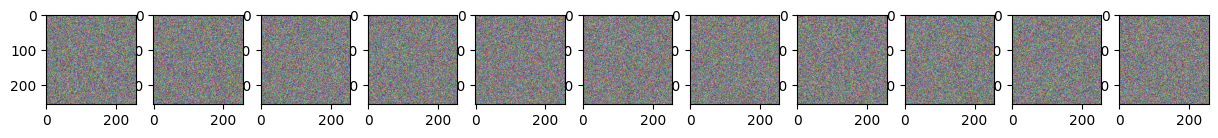

In [ ]:
from torchvision import transforms 
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

# generate a random image
rand_img = torch.randn((1, 3, 256, 256)).to(device)
plt.figure(figsize=(15,15))
plt.axis('off')

num_images = 11
stepsize = 30
model.eval()

label = torch.tensor([random.choice(list(features.keys()))])
text = encode_features(features, label, device)

for i in range(0,steps+1)[::-1]:
    with torch.no_grad():
      t = torch.tensor([i]).to(next(model.parameters()).device)
      rand_img.to(next(model.parameters()).device)
      _rand_img = diffusion_model.p_sample(model, rand_img, t, text)
      rand_img = _rand_img
      if i % stepsize == 0:
          plt.subplot(1, num_images, int(i/stepsize+1))
          show_tensor_image(rand_img.detach().cpu())
plt.show()

references    
DeepFindr https://www.youtube.com/watch?v=a4Yfz2FxXiY    
OpenAI https://github.com/openai/guided-diffusion    
Berkeley https://www.youtube.com/watch?v=687zEGODmHA   
Deep Learning https://www.deeplearningbook.org/contents/monte_carlo.html